<a href="https://colab.research.google.com/github/aso85b/AI-Agent/blob/main/Week_14th_Multiple_myeloma_survival_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***14 th week 2025***
***Multiple myeloma survival Dataset From Kaggle***

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# Load the Coimbra Breast Cancer Dataset
file_path = "/content/MultipleMyelomaSurvival.csv"  # Update with correct path
df = pd.read_csv(file_path)
#Cleaning dataset
# Drop rows with any NaNs in input features or target
data = df.dropna(subset=["Censored"])
data = data.dropna()  # Drop rows with NaNs in any column

# Optionally, reset index
data = data.reset_index(drop=True)


# Define features and target
X = data.drop(columns=["Censored"])
y = data["Censored"]


scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(y.unique())

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(y_train)

# Train logistic regression model for selected features
important_features = ["Age", "Stage"]
lr_model = LogisticRegression()
lr_model.fit(X_train[important_features], y_train)

# Expand training set using predictions
X_train_combined = np.column_stack((X_train, lr_model.predict(X_train[important_features])))
X_test_combined = np.column_stack((X_test, lr_model.predict(X_test[important_features])))


[0. 1.]
117    0.0
11     1.0
5      0.0
94     0.0
78     0.0
      ... 
52     0.0
26     0.0
105    1.0
30     1.0
90     0.0
Name: Censored, Length: 122, dtype: float64


In [13]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, dropout_rate=0.32):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Ensure input_dim matches data
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x


    def predict(self, x):
        #self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            return (probabilities > 0.5).float()

    def erm_score(self, X, y):
        predictions = self.predict(X)
        empirical_risk = np.mean((predictions - y) ** 2)
        return empirical_risk

    def loss_exp(self, predictions, y, reference_preds, alpha):
        empirical_risk = torch.mean((predictions - y) ** 2)
        regularization = alpha * torch.mean((predictions - reference_preds) ** 2)
        #return empirical_risk + regularization
        return regularization # only returns the regularization because the first part of the loss is elsewehere

    def explainability_score(self, X, reference_preds):
        # Measure explainability by comparing the values of the predictions from the model and the reference predictions (user signal)
        predictions = self.predict(X)
        return accuracy_score(reference_preds, predictions)  # Use accuracy score for comparison


Alpha: 0.1, Accuracy: 0.5806, Explainability (Accuracy): 0.8387
Alpha: 0.3, Accuracy: 0.6452, Explainability (Accuracy): 0.9032
Alpha: 0.5, Accuracy: 0.6452, Explainability (Accuracy): 0.9355
Alpha: 0.7, Accuracy: 0.6452, Explainability (Accuracy): 0.9677
Alpha: 1.0, Accuracy: 0.7097, Explainability (Accuracy): 1.0000


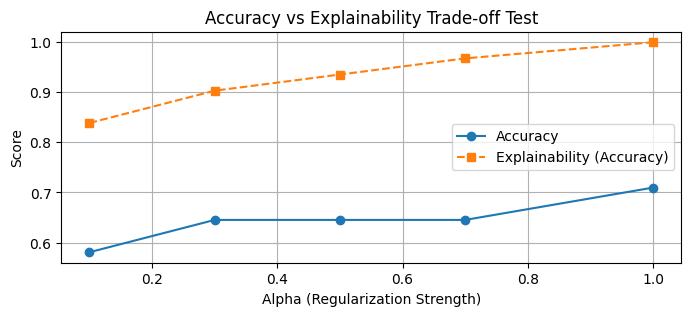

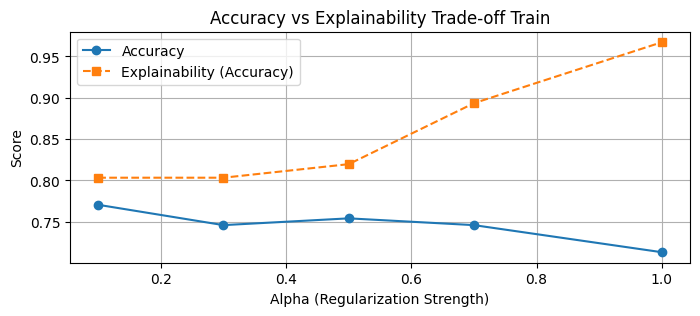

In [14]:
alpha_values = [0.1, 0.3, 0.5, 0.7, 1.0]#[0, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7] # different regularization parameters
accuracy_results = []
explainability_results = []

accuracy_results_train = []
explainability_results_train = []

X_train_combined = torch.FloatTensor(X_train_combined)
X_test_combined = torch.FloatTensor(X_test_combined)
# Ensure y_train and y_test are NumPy arrays before converting to tensors
# Safer and modern way
y_train = torch.FloatTensor(y_train.to_numpy()).reshape(-1, 1)
y_test = torch.FloatTensor(y_test.to_numpy()).reshape(-1, 1)

loss_fn = nn.BCELoss()
# Binary cross-entropy loss: loss_fn(x,y) = y * log(x) + (1-y) * log(1-x) such that log(x) or log(1-x) is greater or equal to -100

for alpha in alpha_values:

    clf = BinaryClassifier(input_dim=X_train_combined.shape[1])

    grad = torch.zeros
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)
    reference_preds = torch.FloatTensor(lr_model.predict(X_train[important_features])).reshape(-1, 1)

    # Model training
    for i in range(200):
        optimizer.zero_grad()   # zero the gradient buffers
        output = clf(X_train_combined)
        #loss = clf.loss_exp(output, y_train, reference_preds, alpha)
        loss1 = loss_fn(output, y_train)
        loss2 = clf.loss_exp(output, y_train, reference_preds, alpha)
        loss = loss1 + loss2
        #print(loss)
        loss.backward()
        optimizer.step()

    #print(loss)
    # Accuracy on the test set
    accuracy = accuracy_score(y_test, clf.predict(X_test_combined))

    # Explainability: measure by the prediction error when comparing the binary classifier and the logistic regression on test set
    explainability = clf.explainability_score(X_test_combined, lr_model.predict(X_test[important_features]))

    #Accuracy on train set
    accuracy_train = accuracy_score(y_train, clf.predict(X_train_combined))

    # Explainability: measure by the prediction error when comparing the binary classifier and the logistic regression on train set
    explainability_train = clf.explainability_score(X_train_combined, lr_model.predict(X_train[important_features]))

    accuracy_results.append(accuracy)
    explainability_results.append(explainability)
    accuracy_results_train.append(accuracy_train)
    explainability_results_train.append(explainability_train)

    print(f"Alpha: {alpha}, Accuracy: {accuracy:.4f}, Explainability (Accuracy): {explainability:.4f}") # test set

# Plot Accuracy vs Explainability
plt.figure(figsize=(8, 3))
plt.plot(alpha_values, accuracy_results, marker='o', label='Accuracy', linestyle='-')
plt.plot(alpha_values, explainability_results, marker='s', label='Explainability (Accuracy)', linestyle='--')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Score")
plt.title("Accuracy vs Explainability Trade-off Test")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(alpha_values, accuracy_results_train, marker='o', label='Accuracy', linestyle='-')
plt.plot(alpha_values, explainability_results_train, marker='s', label='Explainability (Accuracy)', linestyle='--')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Score")
plt.title("Accuracy vs Explainability Trade-off Train")
plt.legend()
plt.grid()
plt.show()